<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-ellaesalex/blob/main/Ejercicios/Regresiones%20y%20K%20means/Kmeans_target_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Actividad Semanal -- 7 Kmeans Target**
Maestría en Inteligencia Artificial Aplicada

Tecnológico de Monterrey

Materia: Ciencia y Analítica de Datos

**Profesor Titular:**
- María de la Paz Rico Fernández

**Profesor Tutor:**
- Roberto Antonio Guevara González

**Nombre de la estudiante:**
- Alejandra Mendoza Flores 

**Matricula:**
- A01793032

**Fecha:**
- 08 de noviembre 2022

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 40.4 MB/s 
     |████████████████████████████████| 1.0 MB 32.1 MB/s 
     |████████████████████████████████| 1.7 MB 64.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 82.5 MB/s 
     |████████████████████████████████| 6.3 MB 68.7 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=5f58bb73f515b4555fdd601ecaeafcbdc31655d85f8865aed8843be52dd86172
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=6c47bc8d10ae68ddd45797d1025e4d0f5667b42380e43f58bd2b680c24f2a28d
  Stored in directory: /root/

In [ ]:
! pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [ ]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [ ]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [ ]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

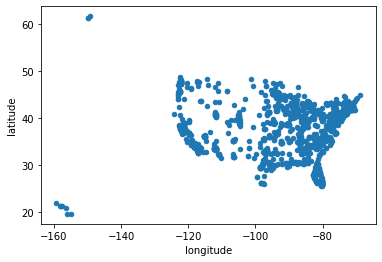

In [ ]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [ ]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [ ]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [ ]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [ ]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

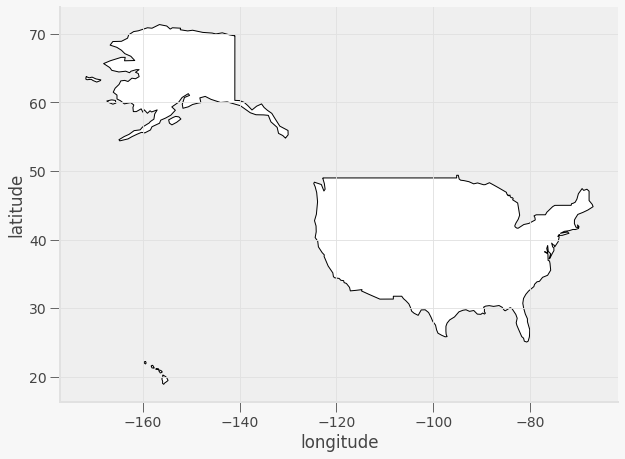

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

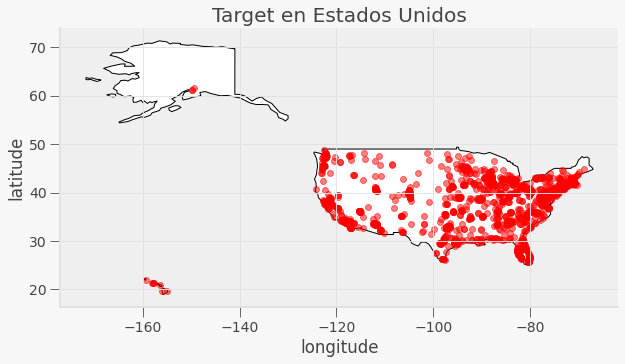

In [ ]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

##**Ejercicio - K means**

Fronteras de decisión

In [ ]:
# extra code – this cell generates and saves Figure 9–3

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


sns.set(style="darkgrid", color_codes=True)
from sklearn.cluster import KMeans

In [ ]:
X = df[['longitude', 'latitude']]

**Número ideal de almacenes**

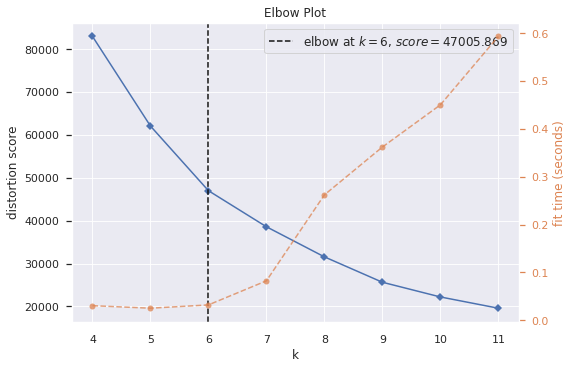

In [ ]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(4, 12))
visualizer.fit(X) #Fit the data to the visualizer
visualizer.title = 'Elbow Plot'
visualizer.show() #Finalize and render the figure

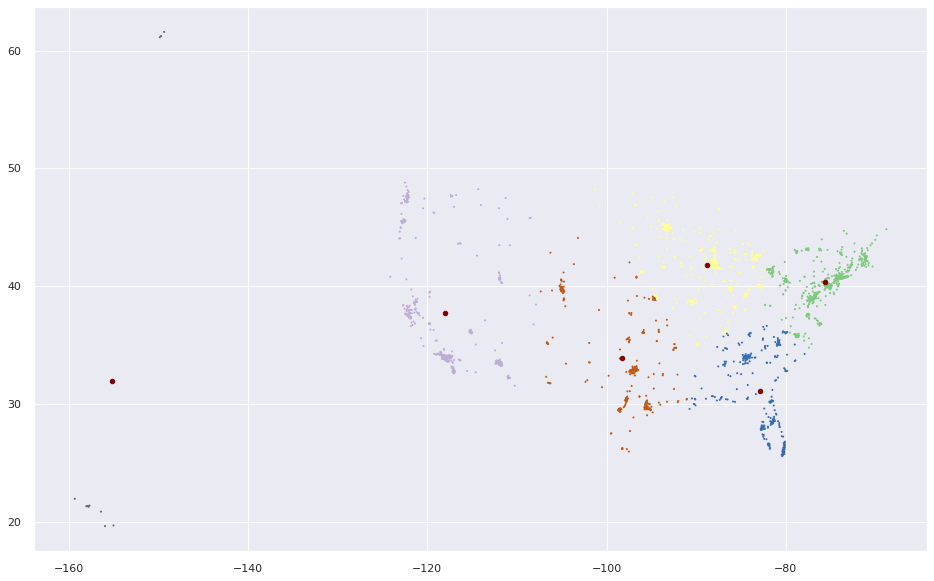

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


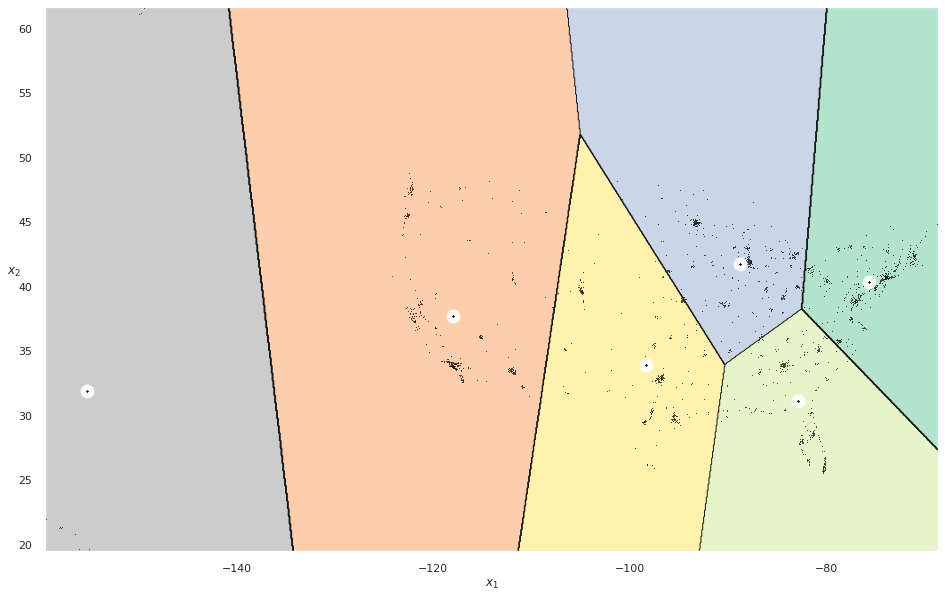

In [ ]:
k = 6

kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)


# graficar los clusters
fig = plt.subplots(figsize=(16,10))
plt.scatter(X['longitude'], X['latitude'], c=y_pred, s=1, cmap='Accent')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c='maroon')
plt.show()

fig = plt.subplots(figsize=(16,10))
plot_decision_boundaries(kmeans, X.values)
plt.show()

Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

Encuentra el numero ideal de almacenes, justifica tu respuesta:

- Encuentra las latitudes y longitudes de los almacenes

In [ ]:
centroids = kmeans.cluster_centers_
coordinates = pd.DataFrame(centroids, columns=['longitude', 'latitude'])
coordinates['coordinates'] = list(zip(coordinates.longitude, coordinates.latitude))
coordinates['point'] = [(x, y) for x, y in zip(coordinates['longitude'], coordinates['latitude'])]
coordinates [['longitude', 'latitude']]

,longitude,latitude
0,-75.652554,40.342401
1,-118.009422,37.752279
2,-88.765089,41.772959
3,-82.901480,31.144378
4,-98.304003,33.913874
5,-155.229853,31.954669


- ¿Qué ciudad es?

In [ ]:
df['point'] = [(x, y) for x, y in zip(df['longitude'], df['latitude'])]

from scipy.spatial.distance import cdist

def closest_point(point, points):
    return points[cdist([point], points). argmin()]

def match_value(df, col1, x, col2):
    return df[df[col1] == x][col2].values[0]

coordinates['closest'] = [closest_point(x, list(df['point'])) for x in coordinates['point']]
coordinates['name'] = [match_value(df, 'point', x, 'name') for x in coordinates['closest']]
                                   
coordinates['name']

0    West Pottsgrove Twp
1                 Clovis
2                 DeKalb
3               Valdosta
4          Wichita Falls
5            Lihue Kauai
Name: name, dtype: object

- ¿A cuántas tiendas va surtir?

In [ ]:
df['cluster'] = y_pred
df['kmeans'] = kmeans.labels_

coordinates['stores_counts'] = df['cluster'].value_counts()

coordinates[['name', 'stores_counts']]

,name,stores_counts
0,West Pottsgrove Twp,484
1,Clovis,359
2,DeKalb,436
3,Valdosta,272
4,Wichita Falls,277
5,Lihue Kauai,11


- ¿Sabes a que distancia estara?

In [ ]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    '''
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    '''
    #convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# calculate distance between each centroid and its closest citv
for index, row in df.iterrows():
    cluster = coordinates.iloc[row['cluster']]
    long, lat = cluster ['point']
    df.loc[index, 'distance_to_distribution_center'] = haversine(row['longitude'], row['latitude'], long, lat)
    df.loc[index, 'distribution_center'] = cluster ['name']


In [ ]:
df[['name', 'distribution_center', 'distance_to_distribution_center']].sort_values(by='distance_to_distribution_center', ascending=True).head(10)

,name,distribution_center,distance_to_distribution_center
1409,West Pottsgrove Twp,West Pottsgrove Twp,8.128533
1411,Exeter Township,West Pottsgrove Twp,17.927572
1412,Royersford,West Pottsgrove Twp,19.629783
554,DeKalb,DeKalb,20.601628
1589,Wichita Falls,Wichita Falls,21.870148
1415,Muhlenberg Township,West Pottsgrove Twp,24.253987
1381,Lower Macungie Twp,West Pottsgrove Twp,26.096072
1410,Richland Twp,West Pottsgrove Twp,26.960965
610,Yorkville,DeKalb,27.739444
1424,Spring Township,West Pottsgrove Twp,28.114920


- ¿Cómo elegiste el numero de almacenes?, justifica tu respuesta tecnicamente?

Se calculó el KElbow con el fin de obtener el mejor número de los almacenes necesarios dentro de los Estados Unidos. Al principio se consideraron únicamente 5 diviciones; sin embargo, se agregó una sexta debido a la lejanía d elos territorios que se conforman por islas y su dificultad del trastalo de las materias y/o productos.


Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, despues nos auxiliamos de una librería de datos geograficos.

- ¿qué librerías nos pueden ayudar a graficar este tipo de datos?
Existe gran diversidad de librarías que podrían apoyar en este caso; sin embargo las más escensiales y utilizadas en el lenguaje Python son: 
1. ArcPy
2. Cartopy
3. Folium
4. GDAL/OGR
5. Geemap
6. GeoPandas
7. GeoPy
8. LiDAR
9. Matplotlib
10. NumPy
11. PyProj
12. PyQGIS
13. PySAL
14. Rasterio
15. whitebox

- ¿Consideras importante que se grafique en un mapa?, ¿por qué?

Es totalmente indispensable, como personas visuales las gráficas ayudan a tener un apoyo visual y entender las divisiones y localicaciones de las soluciones obtenidas, que serán las necesidades presentadas que se buscaban resolver. Estos reportes deberán ser comprendidos por todo aquel involucrado.

- Agrega las conclusiones

K-means se caracteriza por ser método de aprendizaje no supervisado que agrupa puntos de datos, el algoritmo realiza una división iterativa de los puntos de datos en K grupos y minimiza la varianza en cada grupo al realizar la suma de distancias entre cada objeto y el centroide de su grupo o cluster.
Es utilzado para la clasificación y procesamiento de imágenes es por ello que es ideal para solucionar las necesidades de este problema, al identificar una ubicación estratégicas entre los almacenes.


Importante: Entrega en Canvas tu documento en formato PDF /ligas del notebook en colab/github incluyendo las partes de la actividad.